In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
# load some tif images
from PIL import Image

labels_name = ["No cancerous", "Cancerous"]

def get_tif_image_nparray(img):
    imarray = np.array(img)
    return imarray

def plot_tif_image(image, label=None):
    plt.figure(figsize=(4, 4))
    if label is not None:
        plt.title(labels_name[int(label)])
    plt.imshow(get_tif_image_nparray(image))    
    
def plot_image(image, label=None):
    plt.figure(figsize=(4, 4))
    if label is not None:
        plt.title(labels_name[int(label)])
    plt.imshow(image)
    plt.show()
    


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.1)
 
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(5, 5), stride=1, padding=1,)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(16, 16, kernel_size=(5, 5), stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3))
        
        self.conv4 = nn.Conv2d(16, 8, kernel_size=(5, 5), stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(288, 512)
        self.act4 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)
 
        self.fc4 = nn.Linear(512, 1)
 
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        
        x = self.act3(self.conv3(x))
        x = self.pool3(x)
        
        x = self.act4(self.conv4(x))
        x = self.pool4(x)

        x = self.flat(x)
        
        x = self.fc3(x)
        x = self.act4(x)
        x = self.drop3(x)
        
        x = self.fc4(x)
        
        return torch.sigmoid(x)

class VisualizeCNN(ConvNet):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def visualize_layer(self, x, layer):
        if layer >= 1:
            x = self.act1(self.conv1(x))
        if layer >= 2:
            x = self.act2(self.conv2(x))
            x = self.pool2(x)
        if layer >= 3:
            x = self.act3(self.conv3(x))
            x = self.pool3(x)
        if layer >= 4:
            x = self.act4(self.conv4(x))
            x = self.pool4(x)
        return x

In [115]:
# load the model
model = torch.load("checkpoint_5_600.pth") # ConvNet()
vis_model = VisualizeCNN(model)


In [112]:
import pandas as pd

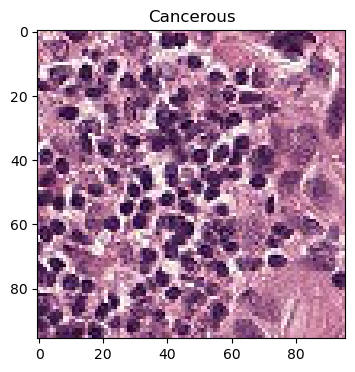

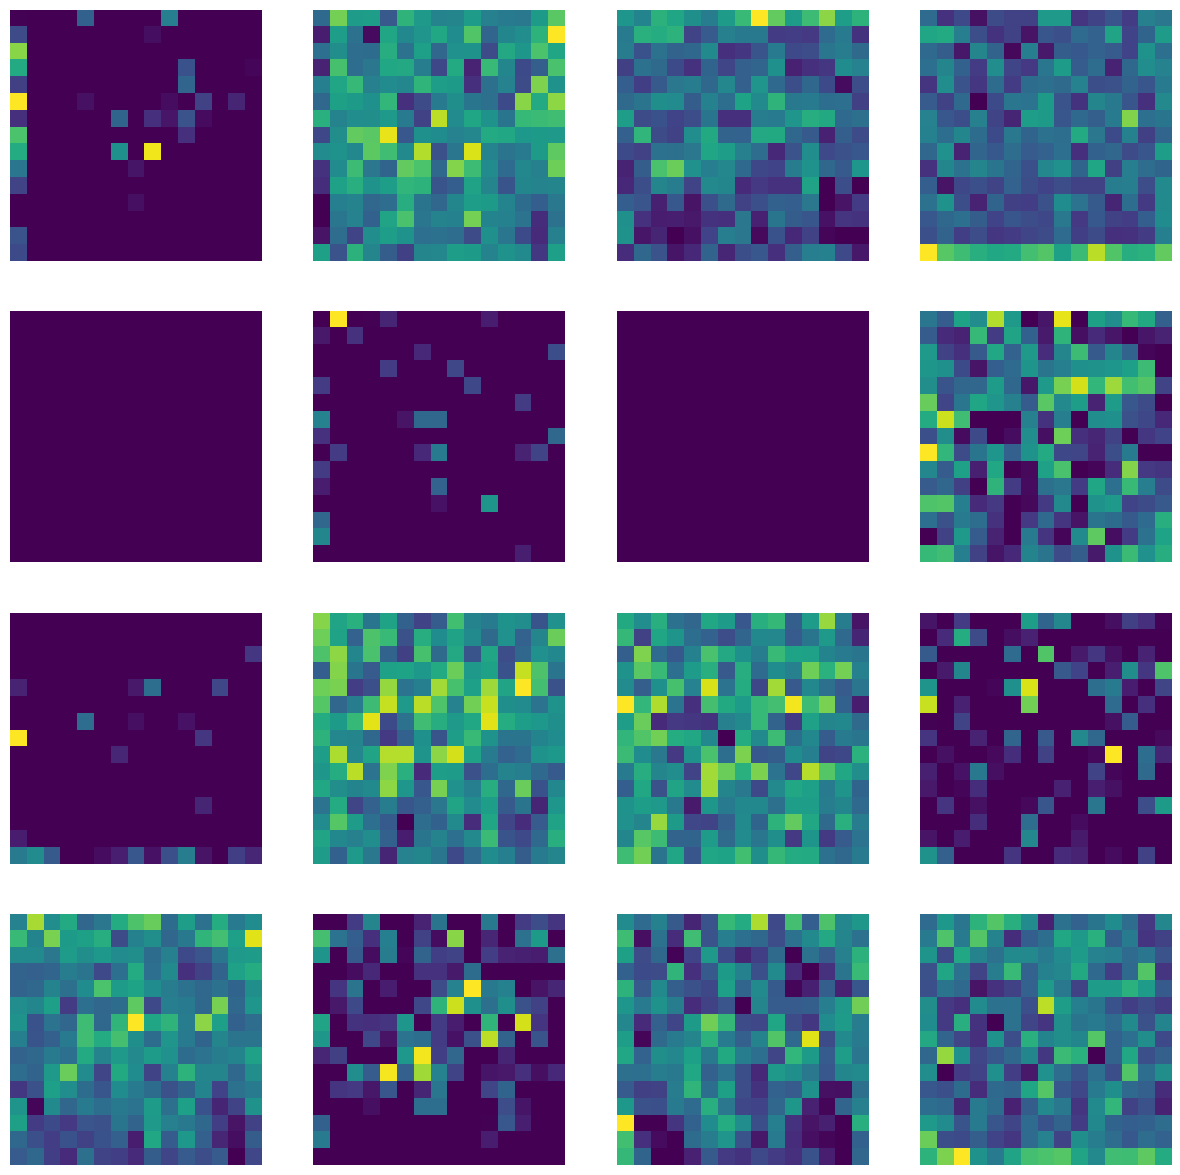

In [119]:
import os

class CustomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.labels = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.labels.iloc[index, 0] + '.tif')
        label = float(self.labels.iloc[index, 1])
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.labels)


transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

df = pd.read_csv('data/train_labels.csv')

dataset = CustomDataset(df, 'data/train/', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
images, labels =  dataset[np.random.randint(0, len(dataset))]

plot_image(images.T, labels)
masked = vis_model.visualize_layer(images, 3).detach().numpy()
# plot all the masks as matrix with figsize 16x16
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1,)
    plt.imshow(masked[i])
    plt.axis('off')   